<a href="https://colab.research.google.com/github/arindamroy-eng/Pytorch-and-other-ML-Experiments/blob/main/Pytorch_Custom_CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

training_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
training_loader = DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)

validation_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)





100%|██████████| 9912422/9912422 [00:00<00:00, 120215911.44it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 99700159.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44607430.37it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1898597.64it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  # Swap (1,28,28) to (28, 28, 1)
  image = image.transpose(1,2,0)
  #print(image)
  #normalize. Image data ranges form 0-255. Convert to range -1 to 1
  image = image + np.array((0.5, 0.5,0.5)) + np.array((0.5, 0.5,0.5))
  # limit all the values between 0 and 1
  image = image.clip(0,1)

  return image

In [ ]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
#print(images[0].size(), labels[0])

'''
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title(labels[idx].item())
'''


'\nfig = plt.figure(figsize=(25,4))\n\nfor idx in np.arange(20):\n  ax = fig.add_subplot(2, 10, idx+1)\n  plt.imshow(im_convert(images[idx]))\n  ax.set_title(labels[idx].item())\n'

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
    self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
    self.fc1 = nn.Linear(4*4*50, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)
  def forward (self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

model = LeNet().to(device)

model


LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



In [ ]:
epochs = 12
running_loss_history = []
running_corrects_history = []

val_running_loss_history = []
val_running_loss_corrects = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # No need to flatten in the next line for CNN
    #inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data).cpu()
    running_loss += loss.item()
  else:
    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          #val_inputs = val_inputs.view(inputs.shape[0], -1)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels)

          _, val_preds = torch.max(val_outputs, 1)
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(val_preds == val_labels.data).cpu()

    epoch_loss = running_loss / len(training_loader)
    epoch_accuracy = running_corrects.float()/len(training_loader)
    running_corrects_history.append(epoch_accuracy)
    running_loss_history.append(epoch_loss)
    #print(f"training loss:{epoch_loss:.4f}, {epoch_accuracy.item():.4f}")
    val_epoch_loss = val_running_loss / len(validation_loader)
    val_epoch_accuracy = val_running_corrects.float()/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_loss_corrects.append(val_epoch_accuracy)

    print(f"Epoch count:{e}")
    print(f"training loss:{epoch_loss:.4f}, {epoch_accuracy.item():.4f}")
    print(f"validation loss:{val_epoch_loss:.4f}, {val_epoch_accuracy.item():.4f}")


Epoch count:0
training loss:0.2160, 93.6917
validation loss:0.0966, 97.1700
Epoch count:1
training loss:0.1296, 96.4317
validation loss:0.1311, 96.6900
Epoch count:2
training loss:0.1252, 96.7017
validation loss:0.1194, 96.7300
Epoch count:3
training loss:0.1204, 96.8083
validation loss:0.1349, 96.4900
Epoch count:4
training loss:0.1289, 96.8050
validation loss:0.1076, 97.3200
Epoch count:5
training loss:0.1274, 96.7733
validation loss:0.1330, 96.7700
Epoch count:6
training loss:0.1243, 97.0433
validation loss:0.1427, 96.2800
Epoch count:7
training loss:0.1341, 96.8183
validation loss:0.1405, 96.7300
Epoch count:8
training loss:0.1363, 96.8583
validation loss:0.1200, 96.6900
Epoch count:9
training loss:0.1131, 97.2017
validation loss:0.1700, 96.5800
Epoch count:10
training loss:0.1258, 97.0150
validation loss:0.1699, 96.3600
Epoch count:11
training loss:0.1312, 96.9767
validation loss:0.1628, 96.7400


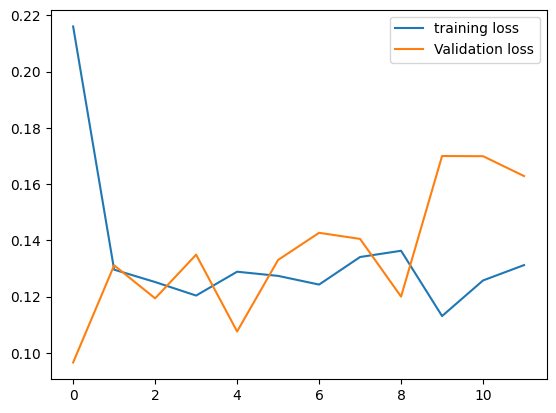

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='Validation loss')
plt.legend()

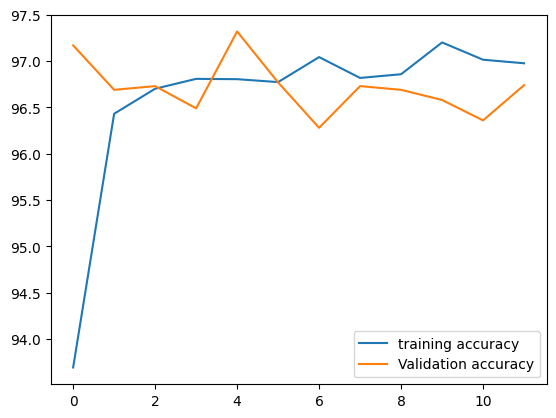

In [ ]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_loss_corrects, label = 'Validation accuracy')
plt.legend()

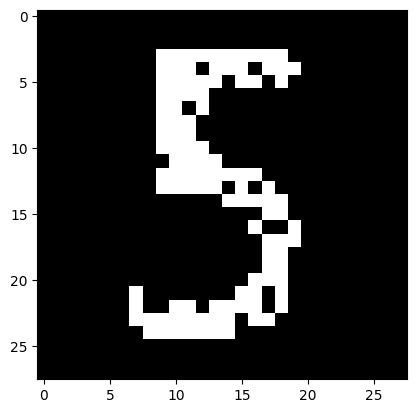

In [ ]:
import requests
from PIL import Image, ImageOps

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'

response = requests.get(url, stream = True)
#print(response)
img = Image.open(response.raw)
#plt.imshow(img)

img = ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
#plt.show(img)
plt.imshow(im_convert(img))
#print(img)

In [ ]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)

output = model(image)
_, pred = torch.max(output, 1)

print(pred.item())


5


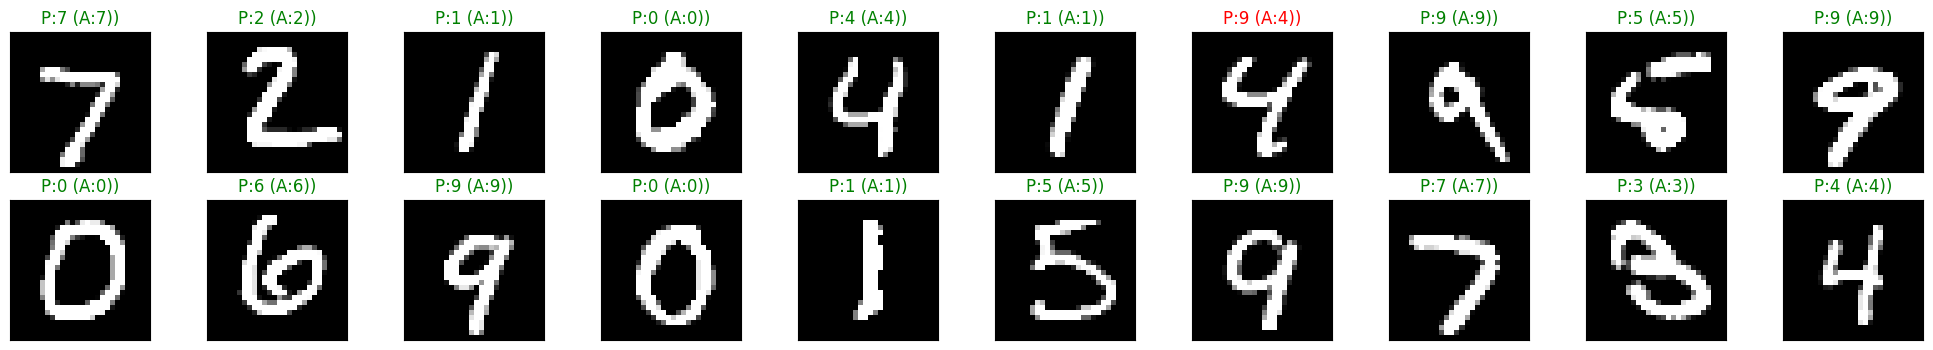

In [ ]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
#images_ = images.view(images.shape[0], -1)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("P:{} (A:{}))".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx] == labels[idx] else "red"))


In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([20, 1, 5, 5])
conv1.bias 	 torch.Size([20])
conv2.weight 	 torch.Size([50, 20, 5, 5])
conv2.bias 	 torch.Size([50])
fc1.weight 	 torch.Size([500, 800])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {0: {'step': tensor(7200.), 'exp_avg': tensor([[[[-7.6871e-29, -7.7068e-29,  7.6304e-29,  7.6302e-29,  5.8848e-29],
          [-7.6094e-29, -7.6289e-29,  7.7351e-29,  5.9892e-29, -7.6316e-29],
          [-7.6244e-29, -7.6672e-29,  7.7100e-29,  2.6082e-29, -7.6303e-29],
          [-7.7037e-29, -7.7235e-29,  7.6306e-29,  7.6248e-29, -5.9409e-29],
          [-7.6083e-29, -7.6204e-29, -7.7406e-30,  7.6780e-29,  7.6301e-29]]],


        [[[ 5.6052e-45, -5.6052e-45, -5.6052e-45, -5.6052e-45, -5.6052e-45],
          [ 5.6052e-45,  5.6052e-45, -5.6052e-45, -5.6052e-45, -5.6052e-45],
          [ 5.6052e-45,  5.6052e-45,  5.6052e-45, -5.6052e-45, -5.6052e-45],
          [ 5.6052